<a href="https://colab.research.google.com/github/miz-ab/10xac_week_two_challenge/blob/main/notebooks/Smart_Ad_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
#import all necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as scs
import statsmodels.api as sm
import seaborn as sns
from sklearn import preprocessing 
from sklearn.preprocessing import scale
from scipy.stats import spearmanr
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import log_loss
from sklearn import metrics
from matplotlib import rcParams
from matplotlib.pyplot import pie, axis, show
from scipy.stats import norm
import xgboost as xgb


In [11]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [14]:
pd.set_option('max_column', None)
df= pd.read_csv('drive/MyDrive/AdSmartABdata .csv')

In [15]:
df.head(3)

,auction_id,experiment,date,hour,device_make,platform_os,browser,yes,no
0,0008ef63-77a7-448b-bd1e-075f42c55e39,exposed,2020-07-10,8,Generic Smartphone,6,Chrome Mobile,0,0
1,000eabc5-17ce-4137-8efe-44734d914446,exposed,2020-07-07,10,Generic Smartphone,6,Chrome Mobile,0,0
2,0016d14a-ae18-4a02-a204-6ba53b52f2ed,exposed,2020-07-05,2,E5823,6,Chrome Mobile WebView,0,1


In [16]:
#filter users who chose "yes" or "no"
responded = df[(df.yes == 1)|(df.no == 1)].reset_index()
#drop the index from the original dataset
responded.drop('index', axis=1, inplace=True)
responded.shape

(1243, 9)

In [17]:
#get unique values of each column
responded.nunique()

auction_id     1243
experiment        2
date              8
hour             24
device_make     115
platform_os       2
browser           8
yes               2
no                2
dtype: int64

In [19]:
def count_plot(variable):
    sns.countplot(x=variable, data=responded)
    
def bar_plot(variable):
    sns.barplot(y=variable, x='yes', data=responded, orient='h')

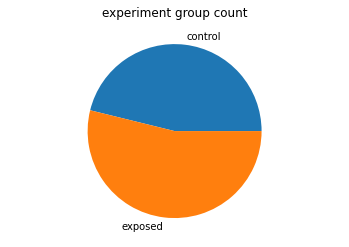

In [20]:
sums = responded["yes"].groupby(responded.experiment).sum()
plt.title("experiment group count")
axis('equal');
pie(sums, labels=sums.index);
show()

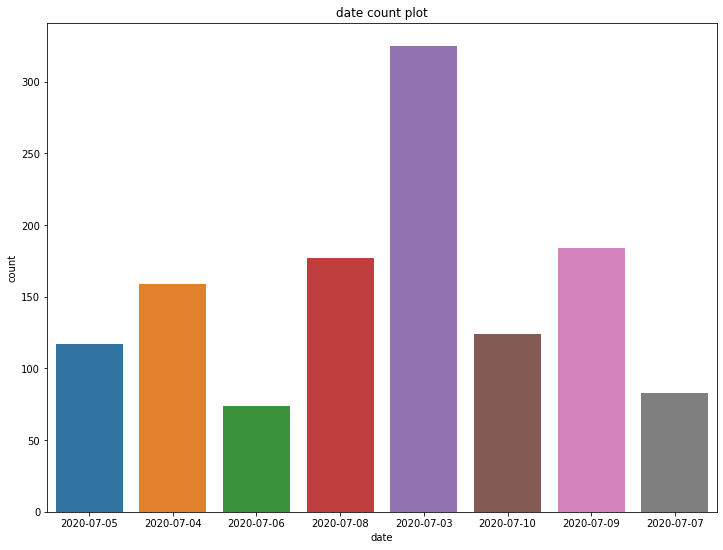

In [22]:
#plot value counts columns
plt.figure(figsize=(12,9))
plt.title("date count plot")
count_plot( "date")

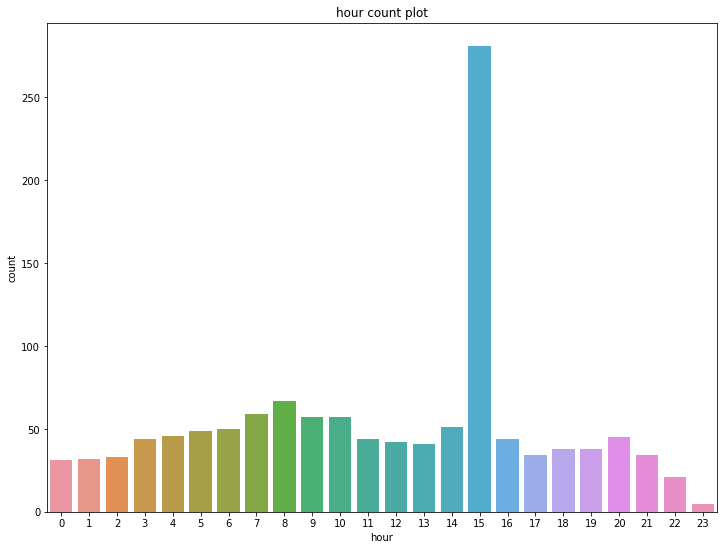

In [24]:
plt.figure(figsize=(12,9))
plt.title("hour count plot")
count_plot( "hour")

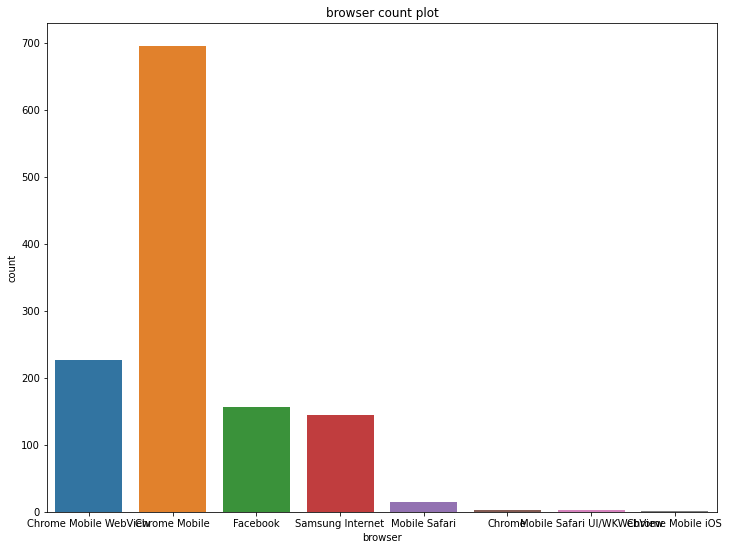

In [26]:
plt.figure(figsize=(12,9))
plt.title("browser count plot")
count_plot("browser")

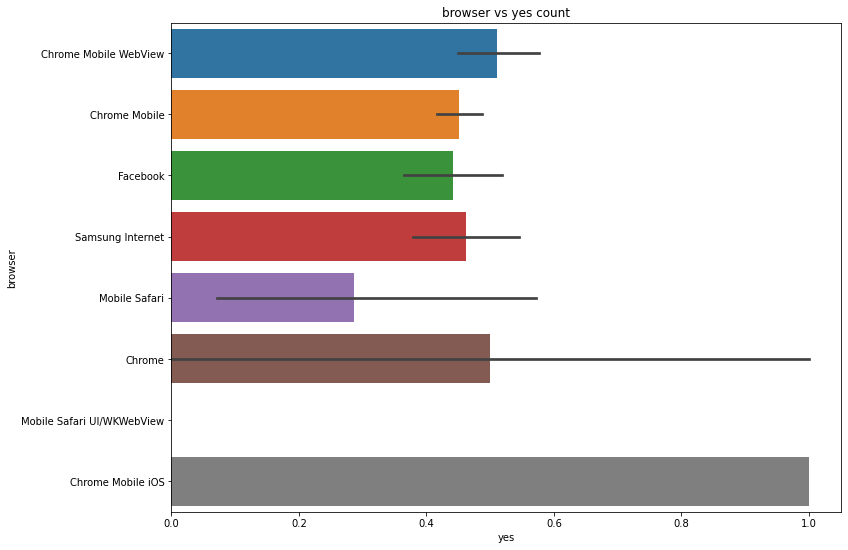

In [28]:
#The plot below shows the portion of users who said "yes" per browser.
plt.figure(figsize=(12,9))
plt.title("browser vs yes count")
bar_plot('browser')

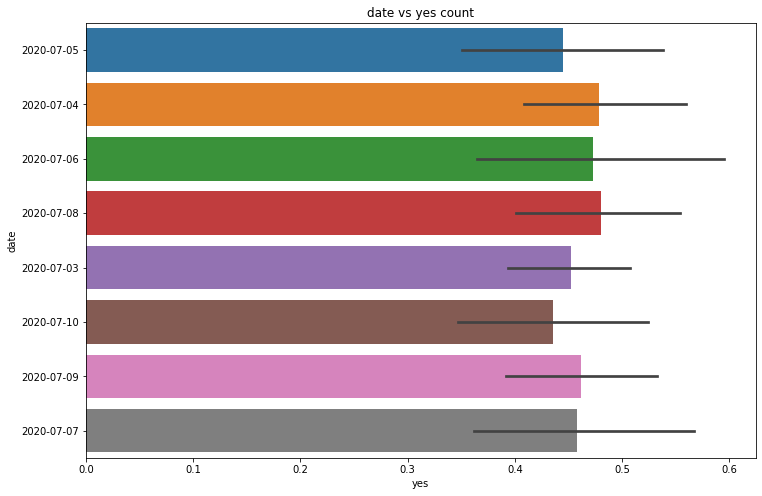

In [29]:
#The plot below shows the portion of users who said "yes" per date.
plt.figure(figsize=(12,8))
plt.title("date vs yes count")
bar_plot('date')

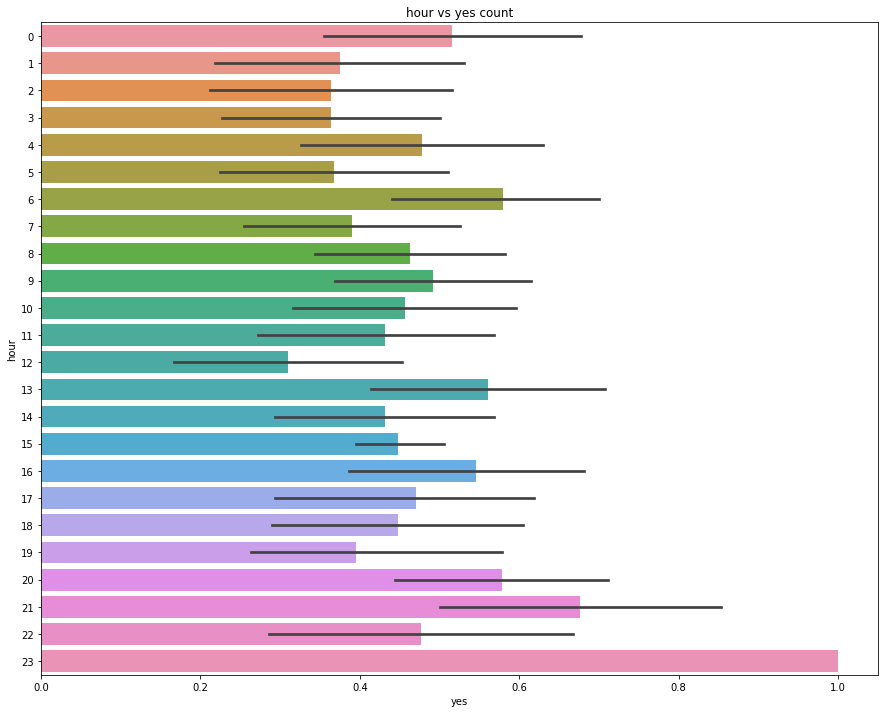

In [30]:
#The plot below shows the portion of users who said "yes" per hour. It looks users responding at 23:00 o'clock, whatever their number, said "yes"
plt.figure(figsize=(15,12))
plt.title("hour vs yes count")
bar_plot('hour')

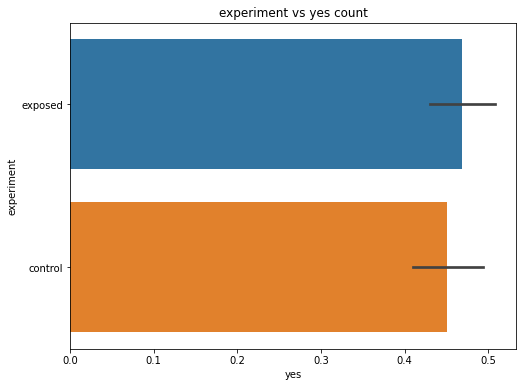

In [31]:
#In the plot below, we can see that more users in the exposed group said yes than in control group. But we need to rely on the A/B test to confirm this.
plt.figure(figsize=(8,6))
plt.title("experiment vs yes count")
bar_plot('experiment')

In [33]:
#Part 2: Classical A/B testing

#Let's carry out classical A/B testing by calculating p-vale using statistical tests

#subset of users with id and group only
users = pd.DataFrame(data = responded[["auction_id", "experiment"]])
#add a column for the response
users["converted"] = responded.yes
users.head(4)

,auction_id,experiment,converted
0,0016d14a-ae18-4a02-a204-6ba53b52f2ed,exposed,0
1,008aafdf-deef-4482-8fec-d98e3da054da,exposed,1
2,00a1384a-5118-4d1b-925b-6cdada50318d,exposed,0
3,00b6fadb-10bd-49e3-a778-290da82f7a8d,control,1


In [34]:
#separate the control and exposed groups
exposed = users[users.experiment == 'exposed']
control = users[users.experiment == 'control']

In [35]:
#pivot table to get the sum of converted users in each group
summary = users.pivot_table(values='converted', index='experiment', aggfunc=np.sum)
# add additional columns to the pivot table
summary['total'] = users.pivot_table(values='converted', index='experiment', aggfunc=lambda x: len(x))
summary['rate'] = users.pivot_table(values='converted', index='experiment')
summary

,converted,total,rate
experiment,,,
control,264,586,0.450512
exposed,308,657,0.468798


In [36]:
control_converted = summary['converted'][0]
control_total = summary['total'][0]
control_rate = summary['rate'][0]

exposed_converted = summary['converted'][1]
exposed_total = summary['total'][1]
exposed_rate = summary['rate'][1]

rate_difference = exposed_rate-control_rate
rate_difference

0.018285619295484168

Text(0, 0.5, 'probability')

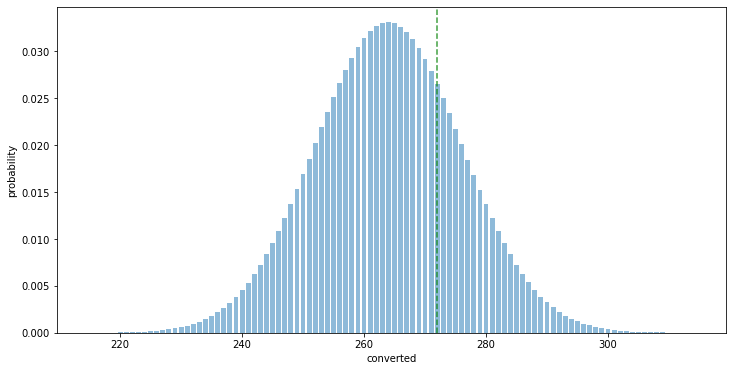

In [37]:

fig, ax = plt.subplots(figsize=(12,6))
x = np.linspace(summary.iloc[0,0]-49, summary.iloc[0,0]+50, 100)
y = scs.binom(control_total, control_rate).pmf(x)
ax.bar(x, y, alpha=0.5)
ax.axvline(x=exposed_rate*580 , c='green', alpha=0.75, linestyle='--')
#ax.axvline(x=exposed_rate*A_total, c='blue', alpha=0.75, linestyle='--')
plt.xlabel('converted')
plt.ylabel('probability')